In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 8)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [4]:
import urllib2
import datetime

import numpy  as np

from astropy import units as u
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, get_sun
from astropy.time import Time
from astropy.utils.data import get_readable_fileobj
from astropy.io import fits
from astropy.table import Table, QTable, Column, MaskedColumn
from astropy import table

In [5]:
# not needed for Astropy>1.2
#import astroplan

#from astroplan import download_IERS_A
#download_IERS_A()

In [6]:
for module in ['hosts', 'targeting', 'aat']:
    if module in globals():
        reload(globals()[module])
    else:
        globals()[module] = __import__(module)
#g = targeting.get_gama() #re-caches the gama catalog

In [7]:
hsd = hosts.get_saga_hosts_from_google(clientsecretjsonorfn='client_secrets.json', useobservingsummary=False)
hsd = dict([(h.name, h) for h in hsd])

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [8]:
def catalog_to_sc(cat, hostordist = None):
    if hasattr(hostordist, 'dist'):
        distance = hostordist.dist
    else:
        distance = hostordist
        
    return SkyCoord(cat['ra']*u.deg, cat['dec']*u.deg, distance=distance)

# Initial planning steps 

In [9]:
#if online
ufo = urllib2.urlopen('https://docs.google.com/spreadsheet/ccc?key=1b3k2eyFjHFDtmHce1xi6JKuj3ATOWYduTBFftx5oPp8&output=csv')
hosttab = QTable.read(ufo.read(), format='csv')
ufo.close()

In [10]:
#if offline
#hosttab = Table.read('SAGADropbox/hosts/host_catalog_flag0.csv')

In [11]:
hostscs = SkyCoord(u.Quantity(hosttab['RA'], u.deg), 
                   u.Quantity(hosttab['Dec'], u.deg), 
                   distance=u.Quantity(hosttab['distance'], u.Mpc))

In [12]:
allspec = Table.read('/Users/erik/Dropbox/SAGA/data/allspectaken_v5.fits.gz')

In [13]:
sagaobsed = allspec[~((allspec['TELNAME']=='NSA')|
                      (allspec['TELNAME']=='SDSS')|
                      (allspec['TELNAME']=='GAMA'))]
sagaobsed_nsaids = np.unique(sagaobsed['HOST_NSAID'])

In [14]:
#UTC time from 8:35-19:35 is AAT 18 deg window
nighttimes = Time('2016-7-28 8:45:00') + np.arange(12)*u.hour
aao = EarthLocation(lon='149:3:57.9', lat='-31:16:37.3')
aao_frame = AltAz(obstime=nighttimes, location=aao)

In [15]:
sunaao = get_sun(nighttimes).transform_to(aao_frame)
np.max(sunaao.alt.value)

-15.521588066557504

In [16]:
seczs = []
for sc in hostscs:
    az = sc.transform_to(aao_frame)
    seczs.append(az.secz)
seczs = np.array(seczs)

hrsvis = np.sum((1<=seczs)&(seczs<1.75),axis=1)
visenough = hrsvis>2

In [17]:
aaoobs = astroplan.Observer(aao, 'Australia/NSW')
midnight = aaoobs.midnight(Time('2016-7-28'))

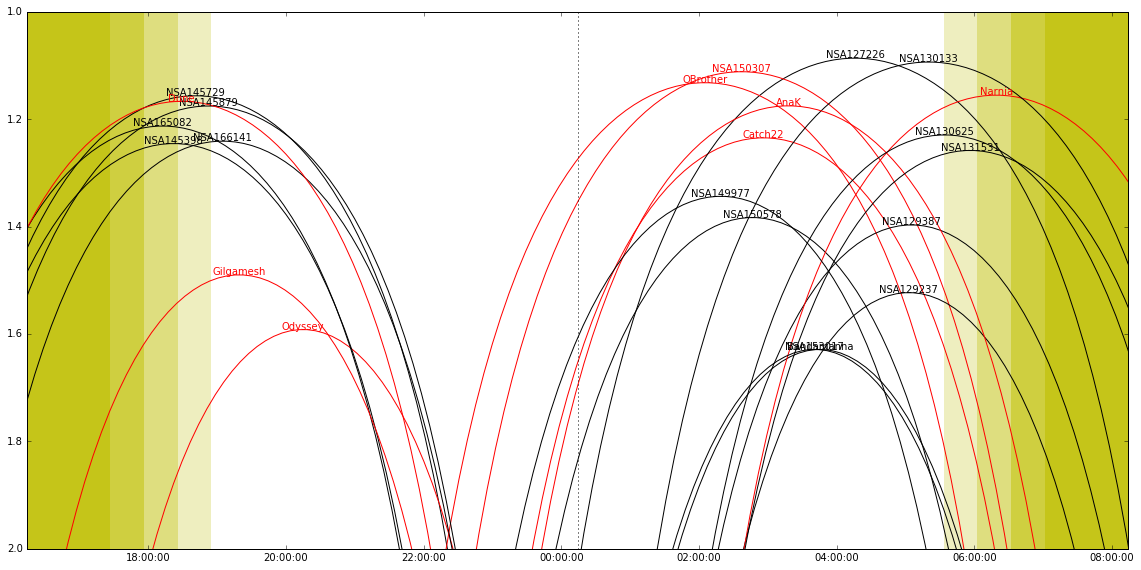

In [24]:
up_times = {}

with open('aat_targets_jul2016/aattargs_iobserve.dat', 'w') as f:
    for host in hosttab[visenough]:
        already_obs = host['NSAID'] in sagaobsed_nsaids
        
        name = 'NSA'+str(host['NSAID'])
        for nm, val in hsd.items():
            if val.nsaid == host['NSAID']:
                name = nm
                if nm.startswith('NSA'):
                    name = name+'_obsed'
                break
        
        f.write(name.replace(' ','_'))
        if already_obs:
            f.write('-observed')
        f.write(' ')
        f.write(str(host['RA']) + ' ')
        f.write(str(host['Dec']) + '\n')
        
        targ = astroplan.FixedTarget(SkyCoord(host['RA'], host['Dec'], unit=u.deg), name)
        
        tpl = (name, host['NSAID'], host['RA'], host['Dec'])
        transit = aaoobs.target_meridian_transit_time(midnight, targ)
        up_times[transit.jd] = tpl
        
        
        timestoplot = transit + np.linspace(-6, 6, 100)*u.hour
        taa = aaoobs.altaz(timestoplot, targ)
        msk = taa.secz >=1
        
        color = 'r' if already_obs else 'k'
        plt.plot(timestoplot.plot_date[msk], taa.secz[msk], c=color)
        plt.text(transit.plot_date, aaoobs.altaz(transit, targ).secz, name, ha='center', color=color)

t0 = aaoobs.sun_rise_time(midnight, 'previous')
t1 = aaoobs.sun_set_time(midnight, 'previous')
t2 = aaoobs.twilight_evening_civil(midnight, 'previous')
t3 = aaoobs.twilight_evening_nautical(midnight, 'previous')
t4 = aaoobs.twilight_evening_astronomical(midnight, 'previous')
t5 = aaoobs.twilight_morning_astronomical(midnight, 'next')
t6 = aaoobs.twilight_morning_nautical(midnight, 'next')
t7 = aaoobs.twilight_morning_civil(midnight, 'next')
t8 = aaoobs.sun_rise_time(midnight, 'next')
t9 = aaoobs.sun_set_time(midnight, 'next')

plt.fill_between([t0.plot_date,t1.plot_date],1,3, lw=0, facecolor='y', alpha=.9)
plt.fill_between([t1.plot_date,t2.plot_date],1,3, lw=0, facecolor='y', alpha=.75)
plt.fill_between([t2.plot_date,t3.plot_date],1,3, lw=0, facecolor='y', alpha=.5)
plt.fill_between([t3.plot_date,t4.plot_date],1,3, lw=0, facecolor='y', alpha=.25)
plt.fill_between([t5.plot_date,t6.plot_date],1,3, lw=0, facecolor='y', alpha=.25)
plt.fill_between([t6.plot_date,t7.plot_date],1,3, lw=0, facecolor='y', alpha=.5)
plt.fill_between([t7.plot_date,t8.plot_date],1,3, lw=0, facecolor='y', alpha=.75)
plt.fill_between([t8.plot_date,t9.plot_date],1,3, lw=0, facecolor='y', alpha=.9)

plt.axvline(midnight.plot_date, ls=':', c='k')

plt.gca().xaxis_date(aaoobs.timezone)
plt.xlim(t1.plot_date-.05, t8.plot_date+.05)
plt.ylim(2,1)
plt.tight_layout()

In [19]:
#NSA urls
for jd in sorted(up_times):
    name, nsaid, ra, dec = up_times[jd]
    print(name, 'http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID={}&submit_form=Submit'.format(nsaid))

NSA165082 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=165082&submit_form=Submit
NSA145398 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=145398&submit_form=Submit
NSA145729 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=145729&submit_form=Submit
NSA145879 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=145879&submit_form=Submit
NSA166141 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=166141&submit_form=Submit
NSA149977 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=149977&submit_form=Submit
NSA150578 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=150578&submit_form=Submit
NSA153017 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=153017&submit_form=Submit
Bandamanna http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=126115&submit_form=Submit
NSA127226 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=127226&submit_form=Submit
NSA129237 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=129237&submit

In [20]:
# DECALS URLs
for jd in sorted(up_times):
    name, nsaid, ra, dec = up_times[jd]
    print(name, 'http://legacysurvey.org/viewer?ra={}&dec={}&zoom=8'.format(ra, dec))

NSA165082 http://legacysurvey.org/viewer?ra=217.418&dec=3.23331&zoom=8
NSA145398 http://legacysurvey.org/viewer?ra=219.796&dec=5.36347&zoom=8
NSA145729 http://legacysurvey.org/viewer?ra=224.594&dec=-1.09102&zoom=8
NSA145879 http://legacysurvey.org/viewer?ra=227.456&dec=0.470085&zoom=8
NSA166141 http://legacysurvey.org/viewer?ra=230.485&dec=5.07063&zoom=8
NSA149977 http://legacysurvey.org/viewer?ra=339.372&dec=10.5315&zoom=8
NSA150578 http://legacysurvey.org/viewer?ra=346.236&dec=12.3229&zoom=8
NSA153017 http://legacysurvey.org/viewer?ra=359.856&dec=20.7498&zoom=8
Bandamanna http://legacysurvey.org/viewer?ra=0.995575&dec=20.7524&zoom=8
NSA127226 http://legacysurvey.org/viewer?ra=8.69484&dec=-8.39644&zoom=8
NSA129237 http://legacysurvey.org/viewer?ra=20.449&dec=17.5922&zoom=8
NSA129387 http://legacysurvey.org/viewer?ra=21.0163&dec=12.9175&zoom=8
NSA130133 http://legacysurvey.org/viewer?ra=24.7772&dec=-7.51266&zoom=8
NSA130625 http://legacysurvey.org/viewer?ra=28.3054&dec=4.19576&zoom=8
N

Notes:
* NSA165082: in DECALS DR2, only z-band, looks like a group, elliptical
* NSA145398: in DECALS DR2, z-band and a bit of g and r, elliptical, otherwise good
* NSA145729: in DECALS DR2, z-band and some r, OK but somewhat near SDSS edge?
* NSA145879: in DECALS DR2, z-band and some g and r, elliptical, otherwise good
* NSA166141: in DECALS DR2, z-band and some g and r, otherwise good
* NSA149977: in DECALS DR2, z-band and some g and r, otherwise good
* NSA150578: in DECALS DR2, only z-band, otherwise good
* NSA153017: in DECALS DR2, only z-band, otherwise good
* Bandamanna: in DECALS DR2, only z-band, otherwise good
* NSA127226: otherwise good
* NSA129237: in DECALS DR2, only z-band, otherwise good
* NSA129387: otherwise good
* NSA130133: elliptical? otherwise good
* NSA130625: S0? otherwise good
* NSA131531: near SDSS edge, otherwise good

# Fitting of gri_err for Marla

In [223]:
from astropy import modeling
from astropy.stats import sigma_clip

In [224]:
ody = hsd['Odyssey']
gilg = hsd['Gilgamesh']
hostobjs = [ody, gilg]
    
for h in hostobjs:
    h.fnsdss = 'SAGADropbox/base_catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None
    
for h in hostobjs:
    h.get_sdss_catalog()

## Experiment with Odyssey

In [249]:
cat = ody.get_sdss_catalog()

In [250]:
gri_err = reduce(np.add, [cat[bandnm+'_err'] for bandnm in 'gri']).view(np.ndarray).astype(float)/3

In [251]:
def plot_data_and_model_residuals(x, y, xlims, ylims, mod, zoomfactor=5):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12, 12))

    xmod = np.linspace(xlims[0], xlims[1], 100)
    ymod = mod(xmod)

    for i, ax in enumerate((ax1, ax2)):
        ax.scatter(x, y, alpha=.02+ .05*i, lw=0,s=3)
        ax.plot(xmod, ymod, c='r')
        ax.set_xlim(*xlims)
        ax.set_xlabel('r mag')
        ax.set_ylabel('(g_err + r_err + i_err)/3')

    ax1.set_ylim(*ylims)
    ax2.set_ylim(0, ylims[1]/zoomfactor)


    for i, ax in enumerate((ax3, ax4)):
        ax.scatter(x, y-mod(x), alpha=.03, lw=0,s=3)
        ax.set_xlim(*xlims)
        ax.set_xlabel('r mag')
        ax.set_ylabel('residuals')
        ax.axhline(0, color='k', ls=':')

    ax3.set_ylim(-ylims[1], ylims[1])
    ax4.set_ylim(-ylims[1]/zoomfactor, ylims[1]/zoomfactor)
    
    return fig

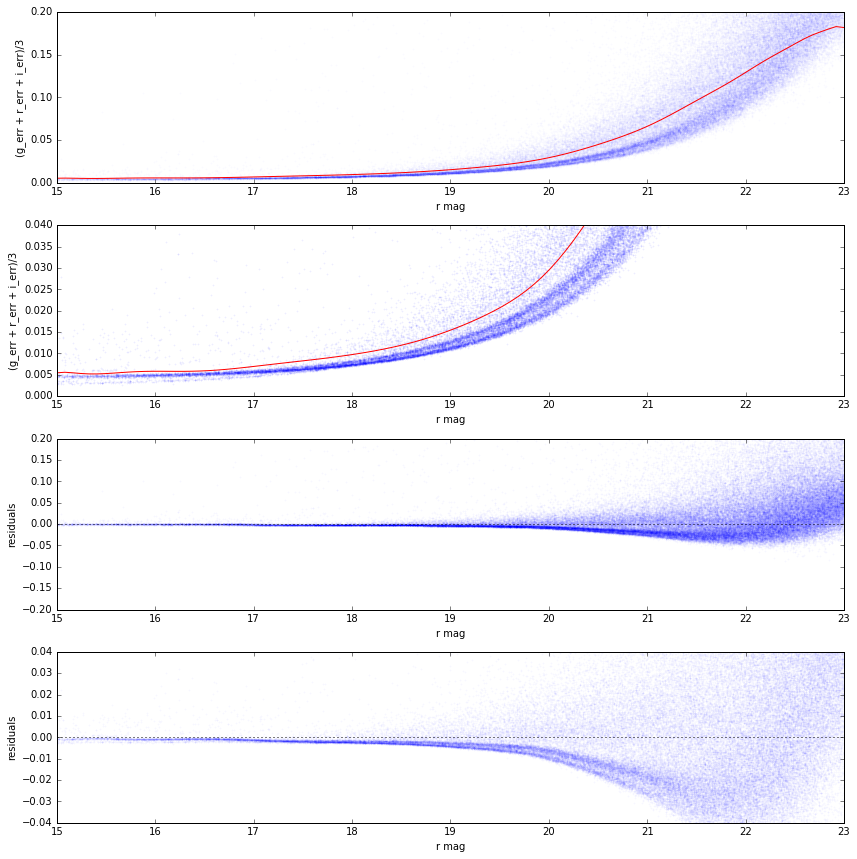

In [252]:
x = cat['r']
y = gri_err


xlims = [15, 23]
ylims = [0, .2]
lims = (xlims[0]<x) & (x<xlims[1]) & (ylims[0]<y) & (y<ylims[1])

mod0 = modeling.models.Polynomial1D(degree=55, domain=xlims, window=[0, 1])
mod = modeling.fitting.LinearLSQFitter()(mod0, x[lims], y[lims])

plot_data_and_model_residuals(x, y, xlims, ylims, mod)
plt.tight_layout()

Just fitting a polynomial doesnt work because of all the outliers.  Try using the binned median and fit *that*

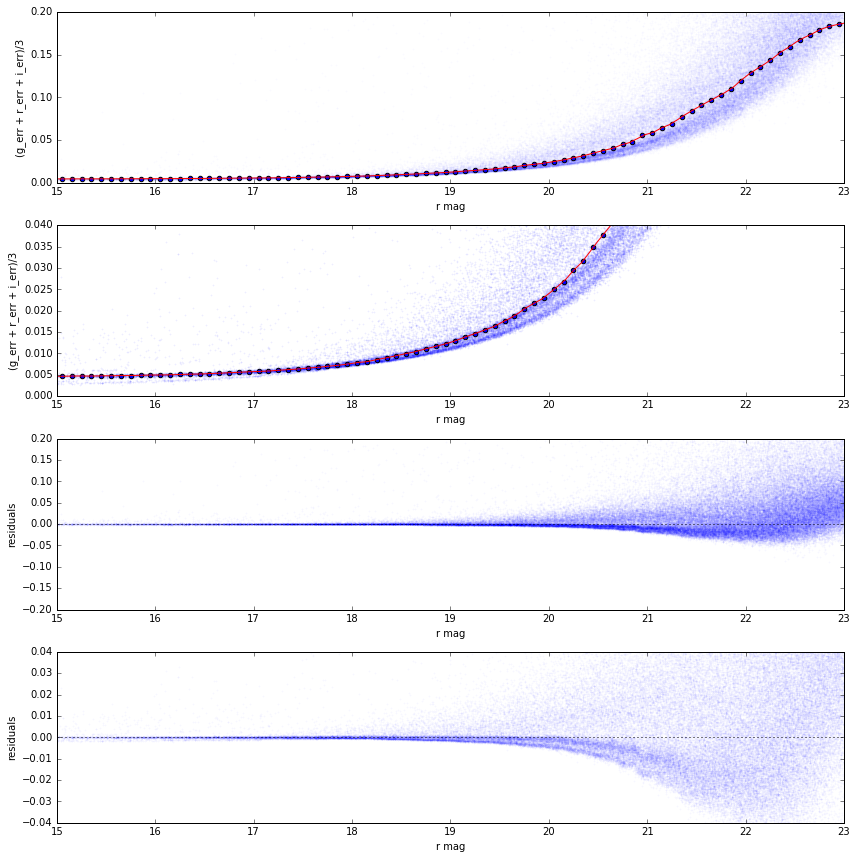

In [253]:
x = cat['r']
y = gri_err


xlims = [15, 23]
ylims = [0, .2]
lims = (xlims[0]<x) & (x<xlims[1]) & (ylims[0]<y) & (y<ylims[1])

binsize = .1
rbins = np.arange(xlims[0], xlims[1]+binsize, binsize)

# first get the values in the bins
binned_errs = [y[(l<x)&(x<u)&(ylims[0]<y)&(y<ylims[1])] for l, u in zip(rbins[:-1], rbins[1:])]
bincens_mag = [(l+u)/2 for l, u in zip(rbins[:-1], rbins[1:])]

#now compute the median in each bin
binvalues = [np.median(b) for b in binned_errs]

mod = lambda x: np.interp(x, bincens, binvalues)

fig = plot_data_and_model_residuals(x, y, xlims, ylims, mod)
fig.axes[0].scatter(bincens, binvalues)
fig.axes[1].scatter(bincens, binvalues)
plt.tight_layout()

Still doesn't look very good.  Lets try sigma-clipping before medianing

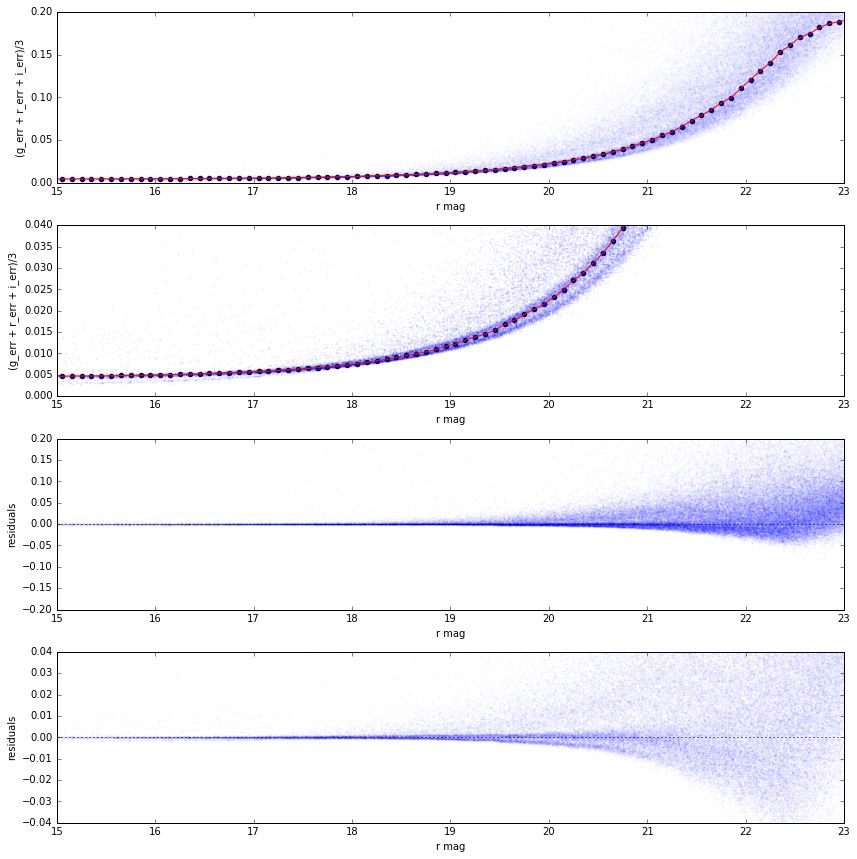

In [254]:
x = cat['r']
y = gri_err


xlims = [15, 23]
ylims = [0, .2]
lims = (xlims[0]<x) & (x<xlims[1]) & (ylims[0]<y) & (y<ylims[1])

binsize = .1
rbins = np.arange(xlims[0], xlims[1]+binsize, binsize)
# first get the values in the bins
binned_errs = [y[(l<x)&(x<u)&(ylims[0]<y)&(y<ylims[1])] for l, u in zip(rbins[:-1], rbins[1:])]
bincens_mag = [(l+u)/2 for l, u in zip(rbins[:-1], rbins[1:])]

#sigma clip and then compute the median of that 
clipped_errs = [sigma_clip(b, sigma=2) for b in binned_errs]
binvalues = [np.median(v[~v.mask])for v in clipped_errs]

mod = lambda x: np.interp(x, bincens, binvalues)

fig = plot_data_and_model_residuals(x, y, xlims, ylims, mod)
fig.axes[0].scatter(bincens, binvalues)
fig.axes[1].scatter(bincens, binvalues)
plt.tight_layout()

Seems more promising.  Now just need a more convenient fit to the binned points

<Polynomial1D(15, c0=0.005149257478939193, c1=-0.09472825642564356, c2=5.358273421872663, c3=-134.39850642689152, c4=1870.454564642886, c5=-16130.383027673597, c6=92235.35916295765, c7=-364811.8217492756, c8=1024022.8001561066, c9=-2066815.7838064728, c10=3005079.4972476815, c11=-3115500.530979867, c12=2243407.7683357825, c13=-1064525.7410173835, c14=298820.0833916113, c15=-37522.3827550569)>

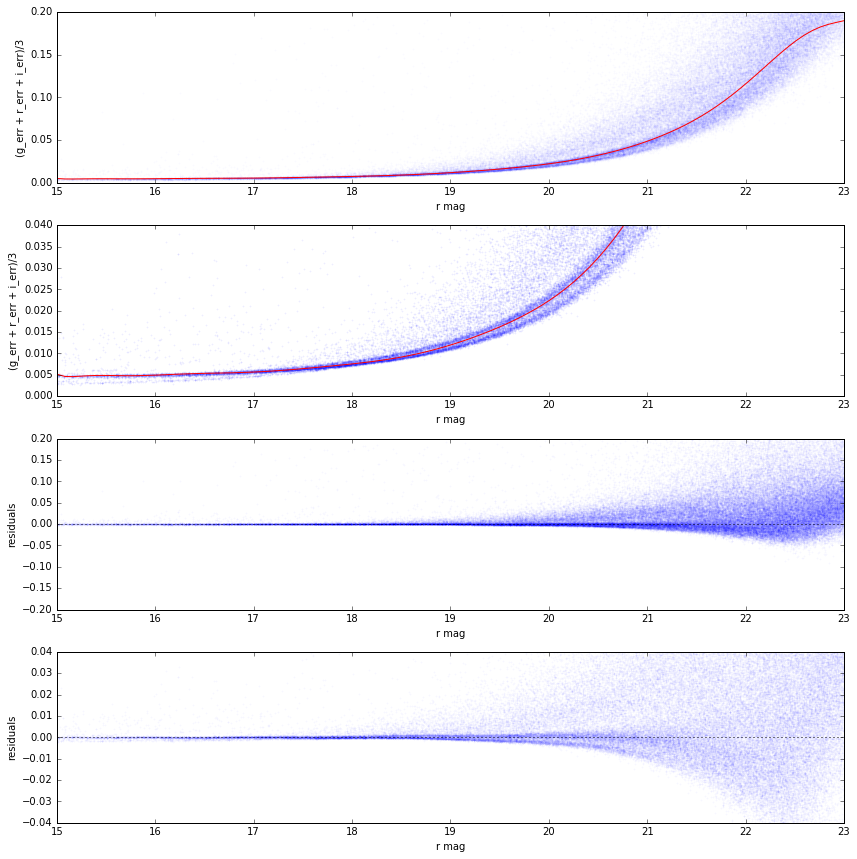

In [255]:
mod0 = modeling.models.Polynomial1D(degree=15, domain=xlims, window=[0, 1])
mod_ody = modeling.fitting.LinearLSQFitter()(mod0, bincens, binvalues)

fig = plot_data_and_model_residuals(x, y, xlims, ylims, mod_ody)
plt.tight_layout()
mod_ody

## See if the same thing works for Gilgamesh 

In [256]:
cat = gilg.get_sdss_catalog()

In [257]:
gri_err = reduce(np.add, [cat[bandnm+'_err'] for bandnm in 'gri']).view(np.ndarray).astype(float)/3

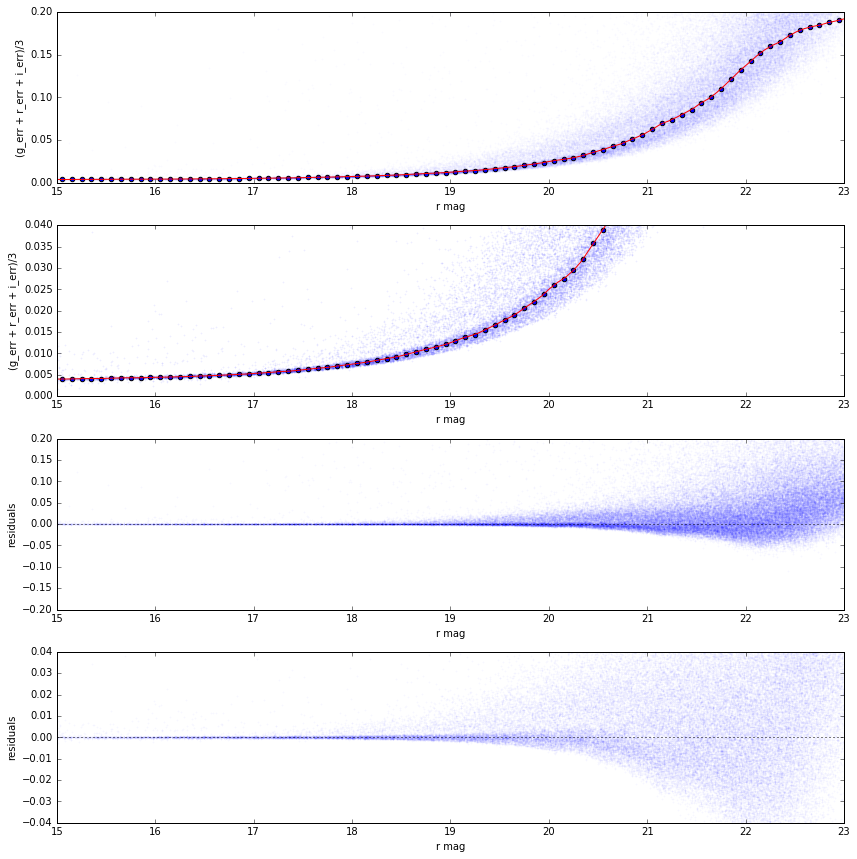

In [258]:
x = cat['r']
y = gri_err


xlims = [15, 23]
ylims = [0, .2]
lims = (xlims[0]<x) & (x<xlims[1]) & (ylims[0]<y) & (y<ylims[1])

binsize = .1
rbins = np.arange(xlims[0], xlims[1]+binsize, binsize)
# first get the values in the bins
binned_errs = [y[(l<x)&(x<u)&(ylims[0]<y)&(y<ylims[1])] for l, u in zip(rbins[:-1], rbins[1:])]
bincens_mag = [(l+u)/2 for l, u in zip(rbins[:-1], rbins[1:])]

#sigma clip and then compute the median of that 
clipped_errs = [sigma_clip(b, sigma=2) for b in binned_errs]
binvalues = [np.median(v[~v.mask])for v in clipped_errs]

mod = lambda x: np.interp(x, bincens, binvalues)

fig = plot_data_and_model_residuals(x, y, xlims, ylims, mod)
fig.axes[0].scatter(bincens, binvalues)
fig.axes[1].scatter(bincens, binvalues)
plt.tight_layout()

Interesting thing to note: the "double-track" is gone

<Polynomial1D(15, c0=0.005610324489241906, c1=-0.32864884665072697, c2=19.07995914130999, c3=-497.5022892711121, c4=7215.1981343815005, c5=-65022.36494900274, c6=389326.05900405993, c7=-1615140.0449518352, c8=4762867.90245408, c9=-10116350.168626405, c10=15509577.110110871, c11=-16994755.360565256, c12=12970884.72635927, c13=-6546123.411848208, c14=1962525.676999017, c15=-264526.3846137787)>

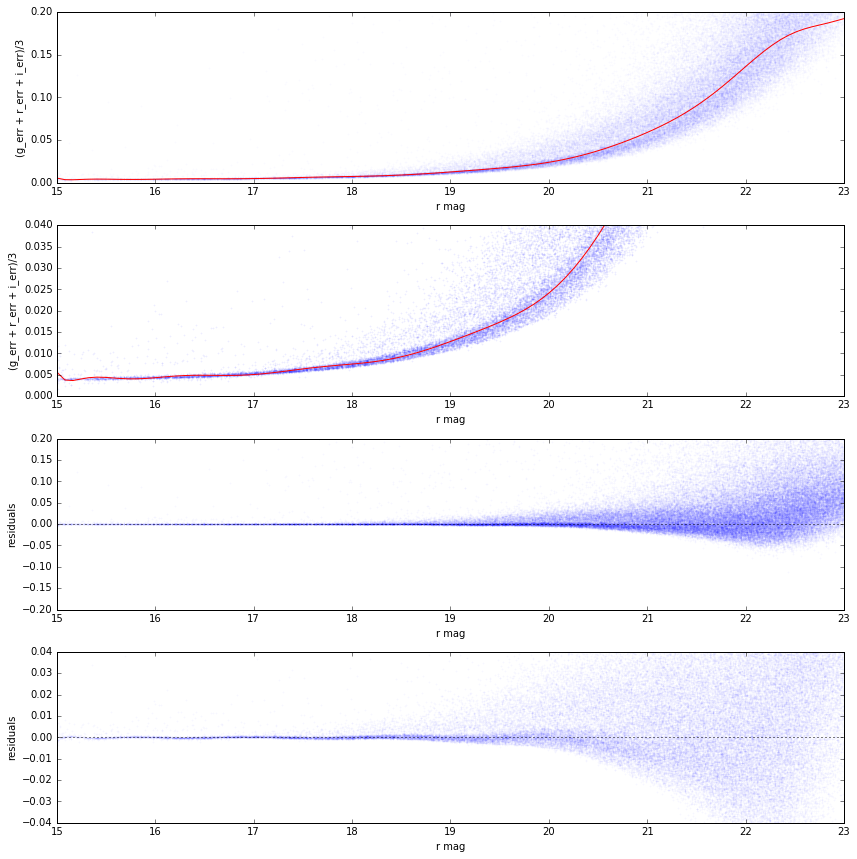

In [259]:
mod0 = modeling.models.Polynomial1D(degree=15, domain=xlims, window=[0, 1])
mod_gilg = modeling.fitting.LinearLSQFitter()(mod0, bincens, binvalues)

fig = plot_data_and_model_residuals(x, y, xlims, ylims, mod_gilg)
plt.tight_layout()
mod_gilg

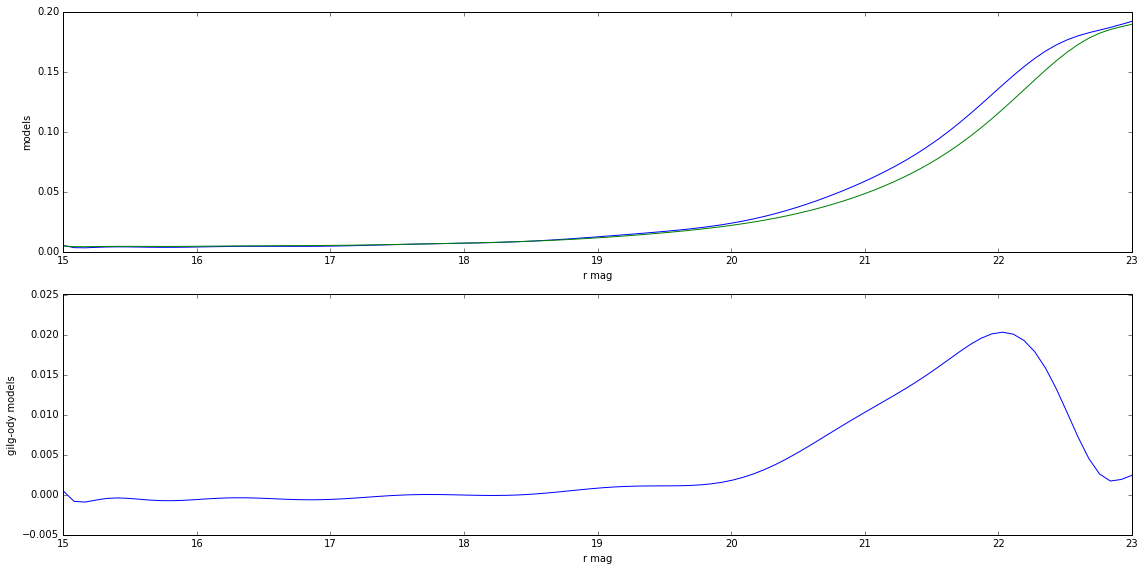

In [260]:
fig, (ax1, ax2) = plt.subplots(2)

x = np.linspace(xlims[0], xlims[1], 100)
ax1.plot(x, mod_gilg(x))
ax1.plot(x, mod_ody(x))

ax2.plot(x, mod_gilg(x)-mod_ody(x))

for ax in (ax1, ax2):
    ax.set_xlabel('r mag')
ax1.set_ylabel('models')
ax2.set_ylabel('gilg-ody models')
plt.tight_layout()

Hmm, looks like it's field-specific...